In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import pathlib
import os
import seaborn as sns
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import joblib
sns.set()
data = pd.read_csv('testset.csv')

In [2]:
data.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [3]:
def overViewOfTheData(data,frows=5,lrows=5):
  print("Shape: ",data.shape,"\n\n")
  
  print("Columns: ",data.columns,"\n\n")

  print("Info : ")
  print(data.info())
overViewOfTheData(data)

Shape:  (100990, 20) 


Columns:  Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object') 


Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 

In [4]:
data = data.drop([' _heatindexm',' _precipm',' _wgustm',' _windchillm'],axis=1)

In [5]:
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))
data['datetime_utc'].head()

0   1996-11-01 11:00:00
1   1996-11-01 12:00:00
2   1996-11-01 13:00:00
3   1996-11-01 14:00:00
4   1996-11-01 16:00:00
Name: datetime_utc, dtype: datetime64[ns]

In [6]:
data = data.set_index('datetime_utc',drop=True)
data.index.name = 'datetime'

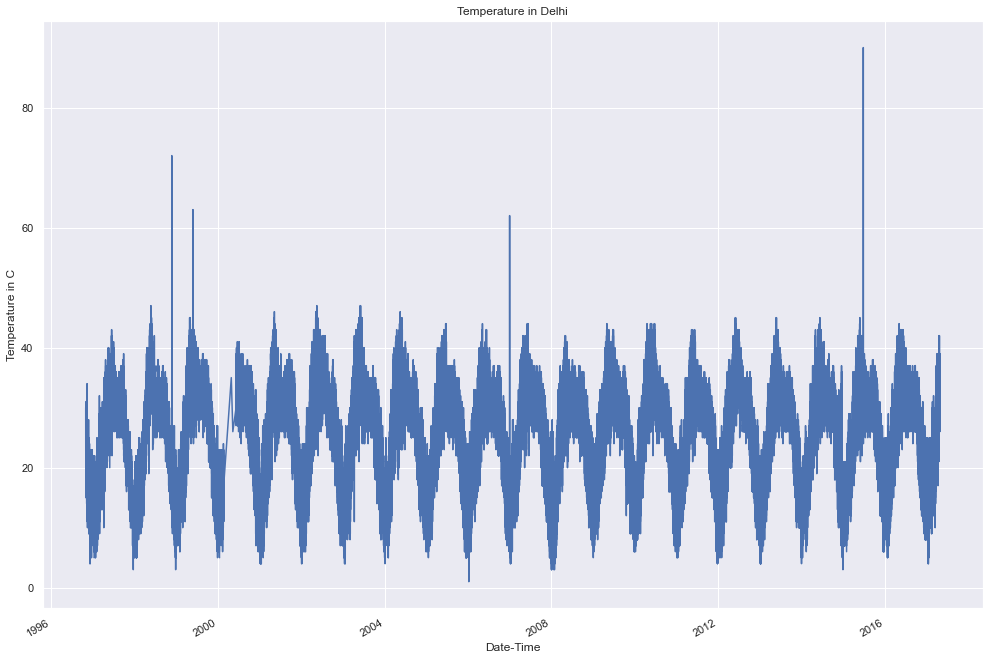

In [7]:
fig, ax = plt.subplots()
data[' _tempm'].plot(figsize=(15,12),ax=ax)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Temperature in C')
ax.set_title('Temperature in Delhi')
plt.show()

In [8]:
data = data['2001':]

In [9]:
newdata = data.resample('D').mean().interpolate()
newdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5958 entries, 2001-01-01 to 2017-04-24
Freq: D
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0    _dewptm     5958 non-null   float64
 1    _fog        5958 non-null   float64
 2    _hail       5958 non-null   float64
 3    _hum        5958 non-null   float64
 4    _pressurem  5958 non-null   float64
 5    _rain       5958 non-null   float64
 6    _snow       5958 non-null   float64
 7    _tempm      5958 non-null   float64
 8    _thunder    5958 non-null   float64
 9    _tornado    5958 non-null   float64
 10   _vism       5958 non-null   float64
 11   _wdird      5958 non-null   float64
 12   _wspdm      5958 non-null   float64
dtypes: float64(13)
memory usage: 651.7 KB


In [10]:
categoricalColumns = list(set(data.columns) - set(data._get_numeric_data().columns))
categoricalColumns
newdata[list(categoricalColumns)] = data[categoricalColumns].resample('D').first().ffill().head()
newdata.head()

,_dewptm,_fog,_hail,_hum,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wspdm,_conds,_wdire
datetime,,,,,,,,,,,,,,,
2001-01-01,9.375000,0.291667,0.0,85.750000,1012.833333,0.25,0.0,11.750000,0.25,0.0,1.205000,55.833333,6.183333,Scattered Clouds,East
2001-01-02,9.125000,0.583333,0.0,82.375000,1016.791667,0.00,0.0,12.333333,0.00,0.0,1.205263,142.916667,3.637500,Fog,North
2001-01-03,10.375000,0.291667,0.0,92.333333,99.208333,0.00,0.0,11.666667,0.00,0.0,1.180952,280.416667,12.191667,Fog,West
2001-01-04,10.208333,0.000000,0.0,94.000000,1018.208333,0.00,0.0,11.208333,0.00,0.0,1.766667,300.416667,15.583333,Overcast,West
2001-01-05,8.791667,0.375000,0.0,87.958333,1017.000000,0.00,0.0,11.000000,0.00,0.0,1.460870,154.583333,8.104167,Overcast,NW


In [11]:
newdata.info

<bound method DataFrame.info of               _dewptm      _fog   _hail       _hum   _pressurem   _rain  \
datetime                                                                  
2001-01-01   9.375000  0.291667     0.0  85.750000  1012.833333    0.25   
2001-01-02   9.125000  0.583333     0.0  82.375000  1016.791667    0.00   
2001-01-03  10.375000  0.291667     0.0  92.333333    99.208333    0.00   
2001-01-04  10.208333  0.000000     0.0  94.000000  1018.208333    0.00   
2001-01-05   8.791667  0.375000     0.0  87.958333  1017.000000    0.00   
...               ...       ...     ...        ...          ...     ...   
2017-04-20  16.750000  0.000000     0.0  27.500000   998.625000    0.00   
2017-04-21  21.500000  0.000000     0.0  39.375000   999.875000    0.00   
2017-04-22  20.400000  0.000000     0.0  40.900000  1001.600000    0.00   
2017-04-23  15.125000  0.000000     0.0  27.500000  1002.125000    0.00   
2017-04-24  14.857143  0.000000     0.0  27.142857  1004.142857    0

In [12]:
train = newdata[:'2015']
test = newdata['2016':]

In [13]:
def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(15,16))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition

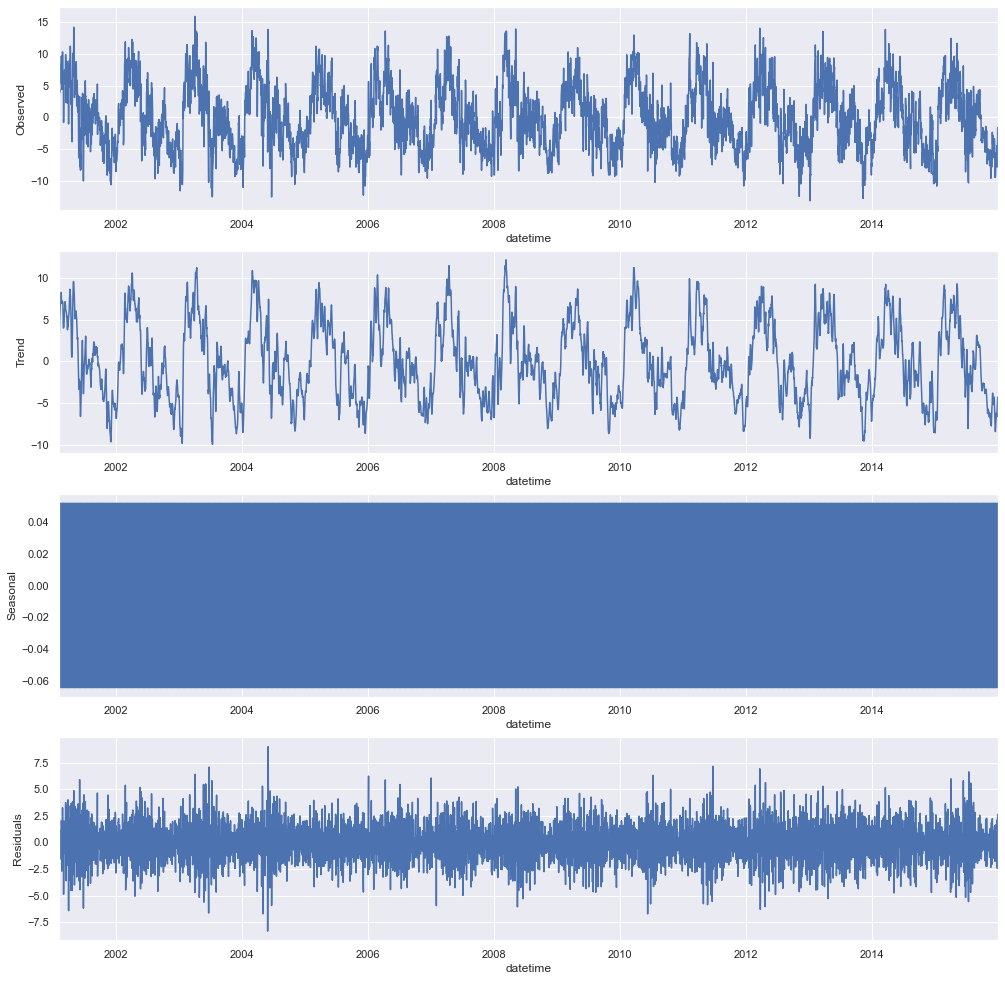

In [14]:
ftraindata = train[' _tempm'].resample('D').mean()
ftestdata = test[' _tempm'].resample('D').mean()
decomposition = decomposeNplot(ftraindata.diff(30).dropna())

In [15]:
results = adfuller(ftraindata.diff(30).dropna())
results

(-6.228641966952172,
 5.016217462792606e-08,
 33,
 5414,
 {'1%': -3.431558423197304,
  '5%': -2.862074001369148,
  '10%': -2.567054248031039},
 22315.69442773787)

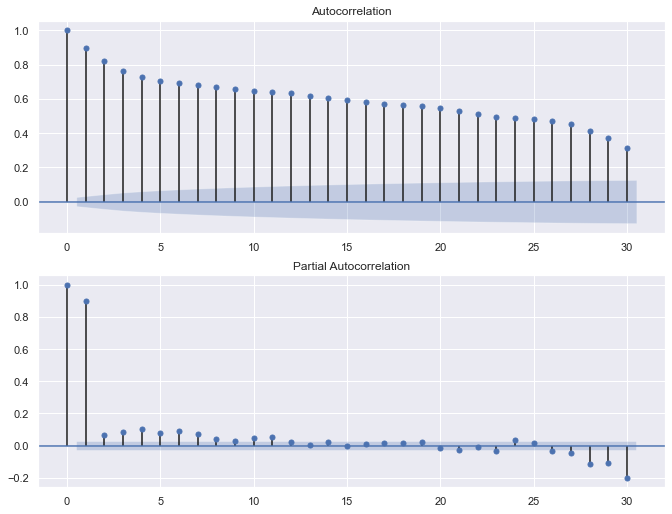

In [16]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(30).dropna(),lags=30,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(30).dropna(),lags=30,ax=ax2)

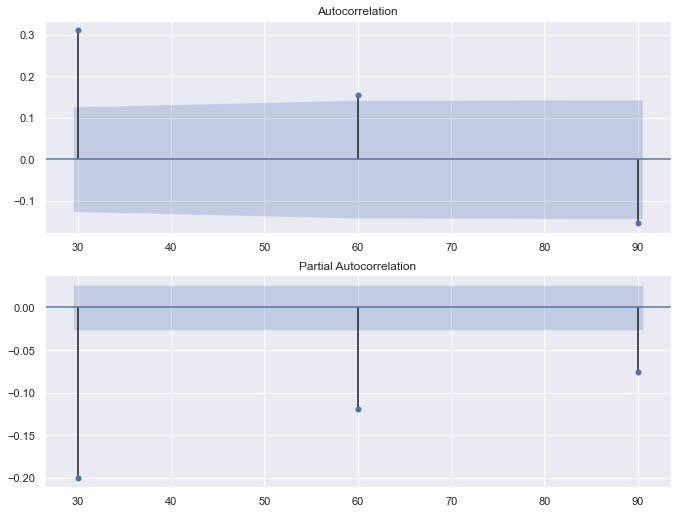

In [17]:
lags = [30*i for i in range(1,4)]

plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(30).dropna(),lags=lags,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(30).dropna(),lags=lags,ax=ax2)

In [26]:
import pmdarima as pm
results = pm.auto_arima(ftraindata,
                    seasonal=True, m=7,
                    d=0,D=1,trace=True,
                    error_action='ignore',
                    suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=15.94 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=27695.839, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=22318.585, Time=1.58 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=24235.816, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=27693.850, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=23743.969, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=21863.758, Time=3.94 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=29.52 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=27211.792, Time=2.10 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=21864.405, Time=4.97 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=21864.261, Time=5.02 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=24177.795, Time=3.46 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=21799.216, Time=24.54 sec
 ARIMA(2,0,1)(1,1,0)[7] intercept 

In [27]:
model = SARIMAX(ftraindata,order=(3,0,1),seasonal=(2,1,0),trend='n')
results = model.fit()


In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 _tempm   No. Observations:                 5478
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -10249.042
Date:                Fri, 22 Jul 2022   AIC                          20508.085
Time:                        14:53:31   BIC                          20541.127
Sample:                    01-01-2001   HQIC                         20519.612
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6445      0.025     66.296      0.000       1.596       1.693
ar.L2         -0.7093      0.025    -28.591      0.000      -0.758      -0.661
ar.L3          0.0646      0.014      4.694      0.000       0.038       0.092
ma.L1         -0.7956      0.023    -34.703      0.000      -0.841      -0.751
sigma2         2.4670      0.037     66.254      0.000       2.394       2.540
===================================================================================
Ljung-Box (Q):                      123.80   Jarque-Bera (JB):               900.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.49
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
print(np.mean(np.abs(results.resid)))

1.1899108045657936


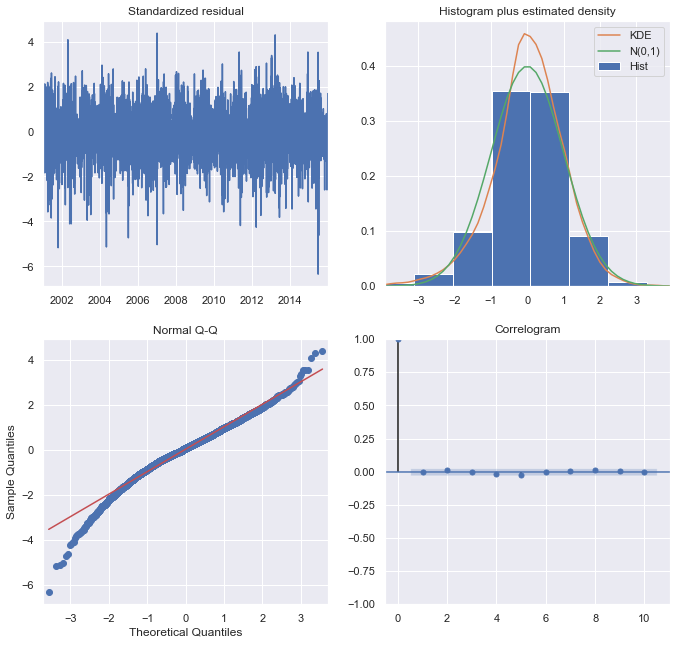

In [30]:
diagnostics = results.plot_diagnostics(figsize=(10,10))

In [31]:
forecast = results.get_forecast(steps=len(ftestdata))

In [32]:
predictedmean = forecast.predicted_mean
bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]

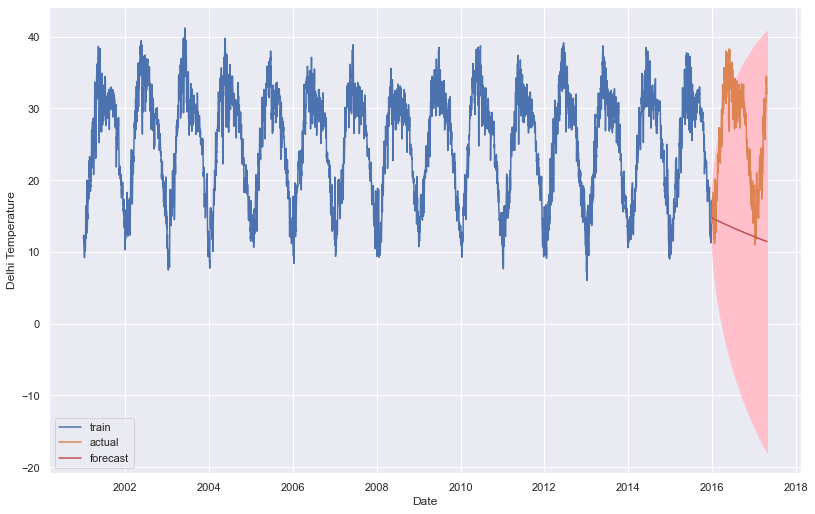

In [33]:
plt.figure(figsize=(12,8))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(ftestdata.index,ftestdata,label='actual')

plt.plot(predictedmean.index, predictedmean, color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')

plt.xlabel('Date')
plt.ylabel('Delhi Temperature')
plt.legend()
plt.show()

In [34]:
print(forecast)

In [35]:
print(predictedmean)

2016-01-01    14.847945
2016-01-02    14.778925
2016-01-03    14.740981
2016-01-04    14.717716
2016-01-05    14.701914
                ...    
2017-04-20    11.462680
2017-04-21    11.456639
2017-04-22    11.450601
2017-04-23    11.444567
2017-04-24    11.438535
Freq: D, Length: 480, dtype: float64
